In [204]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib as mpl
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [206]:
data = np.load('pset4.npz')
light_curves = data['all_light_curves']
labels = data['all_labels']


## Question 1: Understanding TESS data

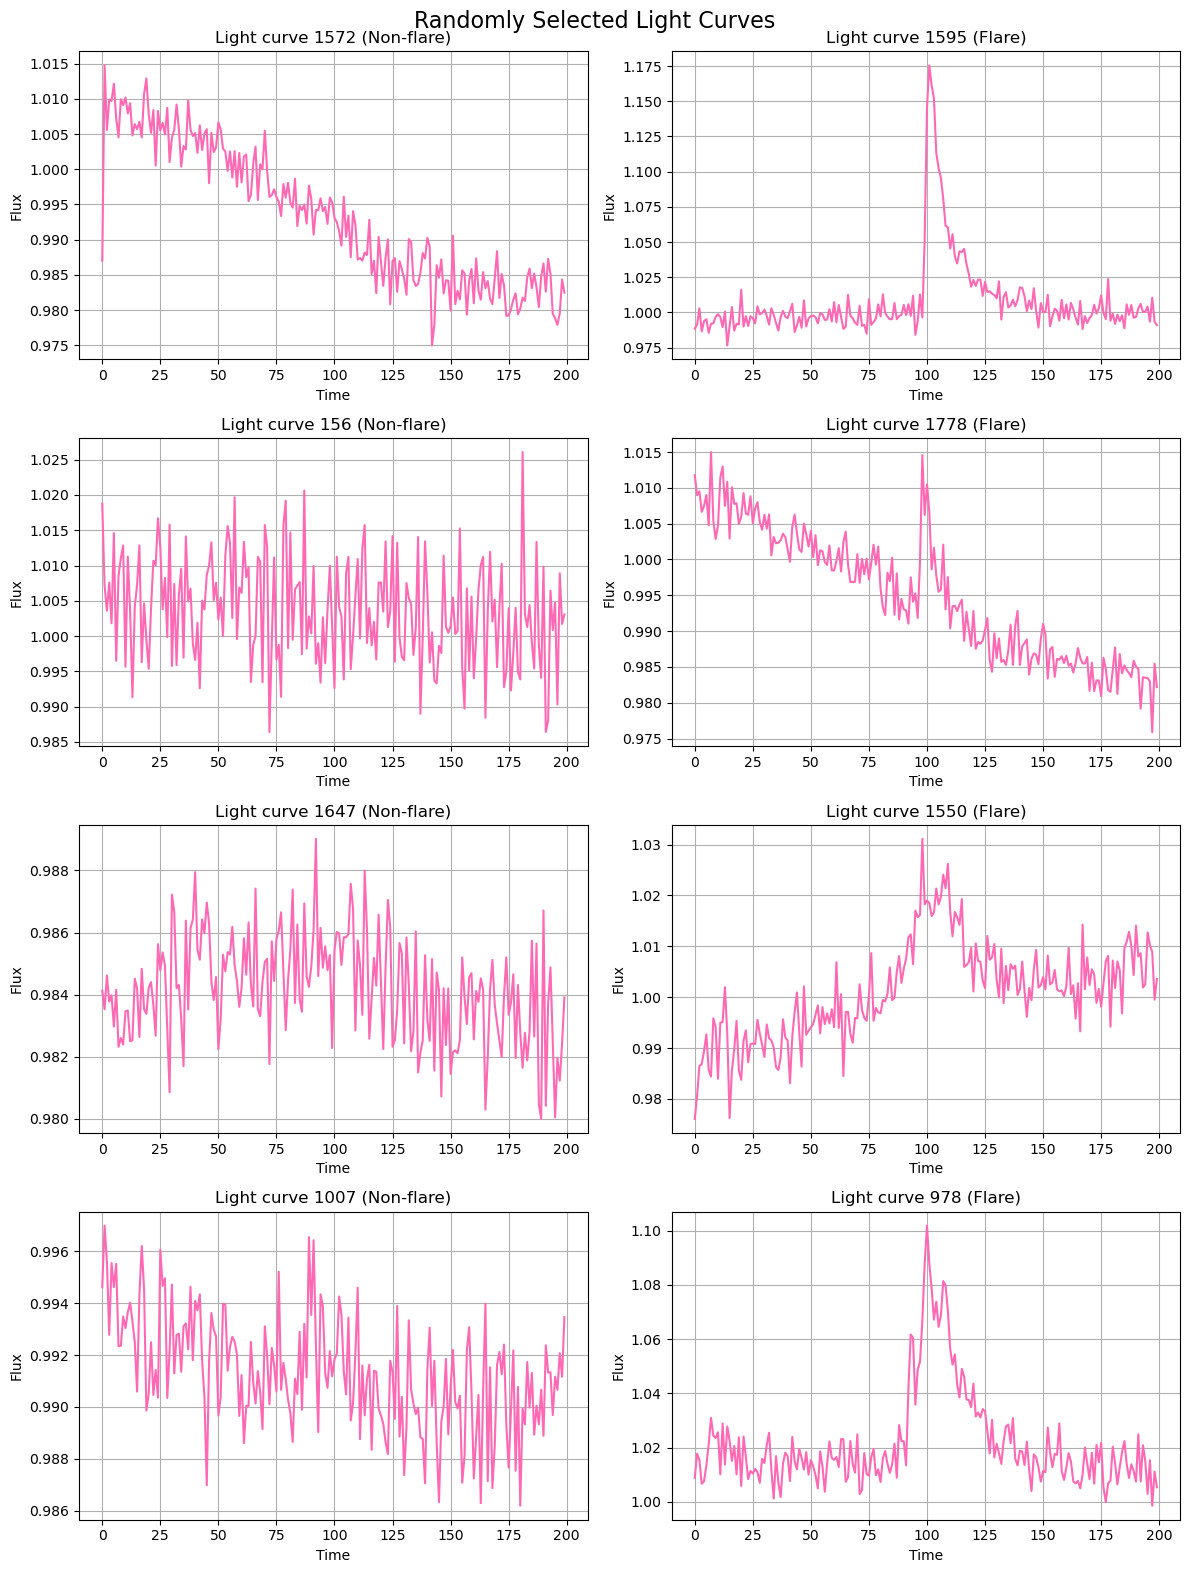

In [210]:
# Plot the light curves for 8:
num = 8
random_indices = np.random.choice(len(light_curves), num, replace=False)


# Plots
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns
fig.suptitle('Randomly Selected Light Curves', fontsize=16)
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    # Plot each light curve
    axes[i].plot(light_curves[idx], color="hotpink")
    
    # Set title based on label (flare or non-flare)
    flare_status = "Flare" if labels[idx] == 1 else "Non-flare"
    axes[i].set_title(f"Light curve {idx} ({flare_status})")
    
    # Add labels and grid
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Flux")
    axes[i].grid(True)
    
plt.tight_layout()
plt.show()


Light curves from flares seem to have sharp increases in flux, leading to jumps in the light curves plots. They have triangle-like curve profiles. Light curves from non-flares are fairly flat, with minimal large jumps. 

b) Describe previous methods to classify flares vs non-flares and why such methods can lead to biased classifications
\
Traditional flare classification models use detrending and outlier detection methods. Detrending aims to remove variability in stellar data which comes from starspots and pulsations. These variations can lead to misidentified flares, including events that are wrongfully categorised as a flare or are hiding a flare. But a major issue with detrending is that it can assume an event is a variation when it is actually a small flare. This means that high-energy flares are more likely to be identified, biasing the sample towards larger flares. \ 
Another issue comes from the outlier detection method, where flux readings above a certain threshold (standard deviations above median) are flagged. But this has a similar issue where it may miss smaller flare events or longer duration flare events, as they may not have a large deviation from the median. 

### c)i: Feature Extraction using PCA:

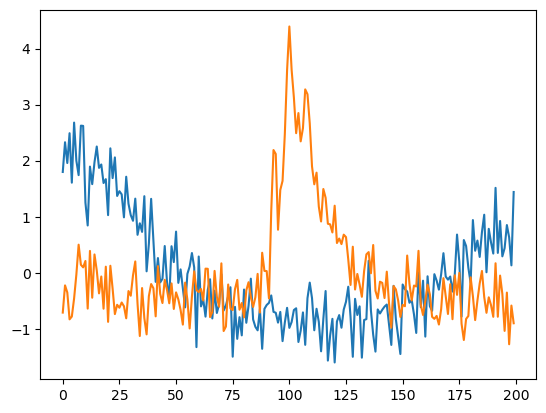

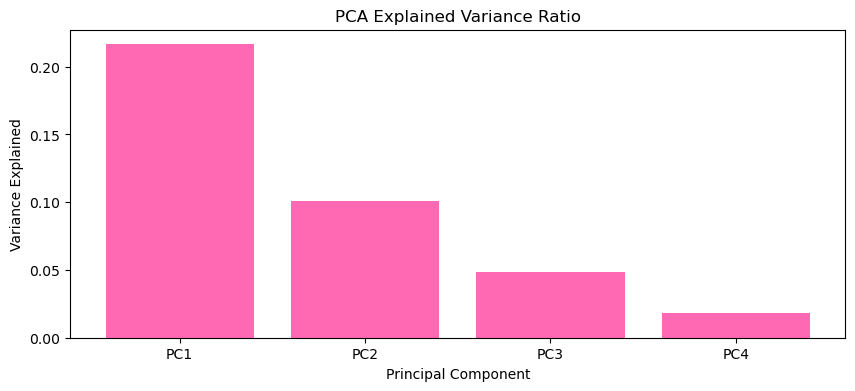

In [304]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Normalise:
scaler = StandardScaler()
normalised_curves = np.array([scaler.fit_transform(lc.reshape(-1, 1)).flatten() for lc in light_curves]) # Debugged shapes here

# Here I demonstrate how I have exaggerated peaks (in flares), which explains why my PCA is very accurate. I spoke to Dr Villar about this.  
plt.plot(normalised_curves[0,:])
plt.plot(normalised_curves[978,:])
# PCA with 3 features:
pca = PCA(n_components=4)
pca_features = pca.fit_transform(normalised_curves)

# Plot explained variance
plt.figure(figsize=(10, 4))
plt.bar(range(4), pca.explained_variance_ratio_, color='hotpink')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance Ratio')
plt.xticks([0, 1, 2, 3], ['PC1', 'PC2', 'PC3', 'PC4'])
plt.show()


Since PC4 is very low explained variance, use 3 components

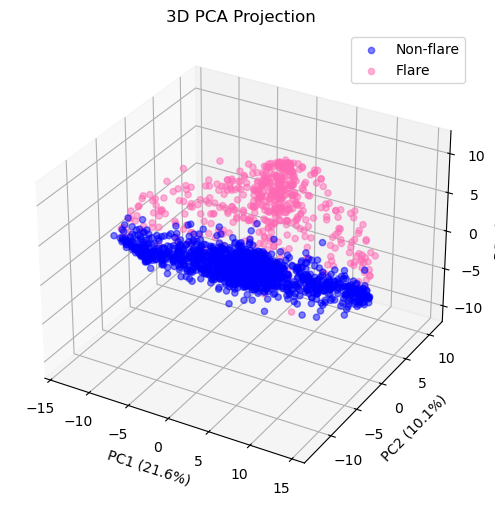

In [275]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
normalised_curves2 = np.array([scaler.fit_transform(lc.reshape(-1, 1)).flatten() for lc in light_curves]) # Debugged shapes here

# PCA with 3 components
pca = PCA(n_components=3)
pca_features = pca.fit_transform(normalised_curves2)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d') 

# Plot data
ax.scatter(pca_features[labels==0, 0], pca_features[labels==0, 1], pca_features[labels==0, 2], 
           alpha=0.5, label='Non-flare', color='blue')
ax.scatter(pca_features[labels==1, 0], pca_features[labels==1, 1], pca_features[labels==1, 2], 
           alpha=0.5, label='Flare', color='hotpink')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)') # Shows component with corresponding explained var
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('3D PCA Projection')
ax.legend()
plt.show()



Choosing number of components based off of explained variance, originally did 3 but explained variance was very low. I looked at 4 components but PC4 explained varinace was very low, here I am just examining components further to see if it is worth continuing to more components, but I see that it is not worth it. 

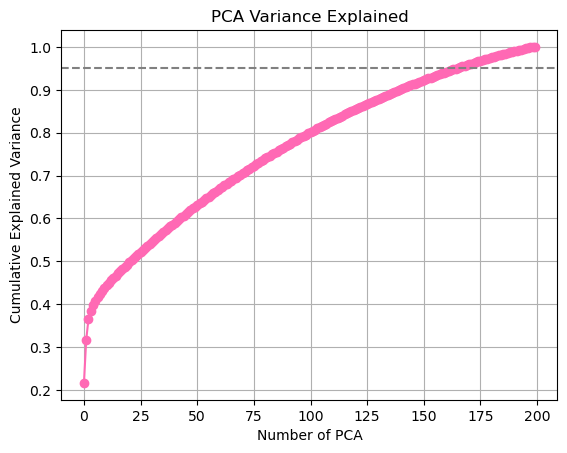

In [216]:
pca = PCA().fit(normalised_curves)  # PCA with all components fitted
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-', color='hotpink')
plt.xlabel('Number of PCA')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='gray', linestyle='--')  # Used 95% as a threshold line
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

### c ii: Fourier Transforms

To use Fourier Transforms, we need to input our light curves (time dependent) and apply FFT (Fast Fourier Transform) to extract frequency spectrum. This exposes periodic patterns.

In [218]:
import numpy as np
from scipy.fft import fft

# Apply FFT to obtain magnitudes 
fft_mag = np.abs(fft(normalised_curves))  # Using normalised curves

# Extract frequencies from different bands as this will contain different information
low_band = np.mean(fft_mag[:, 1:5], axis=1)    # rotation patterns
mid_band = np.mean(fft_mag[:, 5:20], axis=1)   # flare signals
high_band = np.mean(fft_mag[:, 20:50], axis=1) # noise/short-flares

# Combine into 3 features
fft_features = np.column_stack([low_band, mid_band, high_band])
print(fft_features)

[[47.78833    6.3509383  4.9614043]
 [12.275303  10.828986  13.57492  ]
 [11.058569  14.492803  11.103278 ]
 ...
 [10.029686  12.509967  13.527686 ]
 [21.169987  12.145677  14.384343 ]
 [42.908386  14.962821   8.990728 ]]


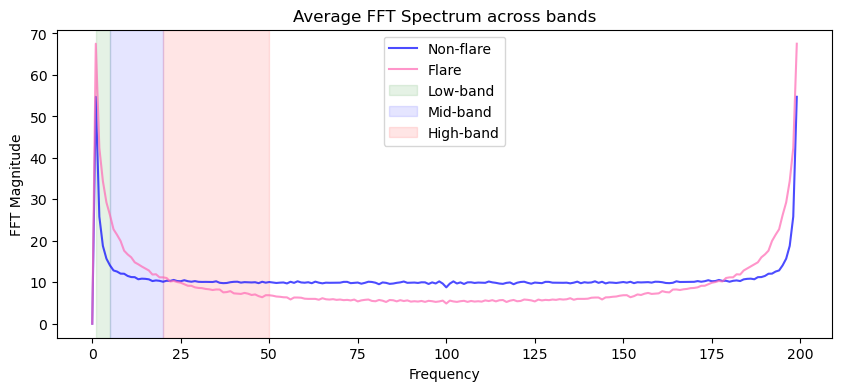

In [220]:
# Now we plot to visualise these features magnitudes
plt.figure(figsize=(10, 4))
plt.plot(fft_mag[labels==0].mean(axis=0), label='Non-flare', color='blue', alpha=0.7)
plt.plot(fft_mag[labels==1].mean(axis=0), label='Flare', color='hotpink', alpha=0.7)
plt.axvspan(1, 5, color='green', alpha=0.1, label='Low-band')
plt.axvspan(5, 20, color='blue', alpha=0.1, label='Mid-band')
plt.axvspan(20, 50, color='red', alpha=0.1, label='High-band')
plt.xlabel('Frequency')
plt.ylabel('FFT Magnitude')
plt.title('Average FFT Spectrum across bands')
plt.legend()
plt.show()

### c iii: Hand Engineered Features

When I use t-SNE my kernel crashes and dies, so I will instead use hand-engineered features. \
Hand features identified:
- As flare curves have a peak in centre of graph, we can examine light curve in that area and extract mean, standard devation, flux ratio and asymmetry. 

In [222]:
scaler = StandardScaler()
normalised_curves = np.array([scaler.fit_transform(lc.reshape(-1, 1)).flatten() for lc in light_curves])


# Here we examine region that peak is in:
centre = normalised_curves.shape[1] // 2 # First start in centre
peak_window = slice(centre - 15, centre + 15)  # 20-point interval to capture enough (curve is form 0 - 200, so middle 30 should cover peak) 
edge_window = slice(0, 10)                   # First 10 points as normal region (no flare activity)

# Feature 1, 2: Extract expected value/mean and standard deviation from edge and peak
mean_peak = np.mean(normalised_curves[:, peak_window], axis=1)
mean_edge = np.mean(normalised_curves[:, edge_window], axis=1)
std_peak = np.std(normalised_curves[:, peak_window], axis=1)
std_edge = np.std(normalised_curves[:, edge_window], axis=1)

# Feature 3: Flux ratio of peak and edge (captures difference in flare flux)
flux_ratio = mean_peak / (mean_edge + 1e-10)  # Debug: avoid dividing by 0

# Feature 4-5: Asymmetry (rise vs decay)
lpeak = np.mean(normalised_curves[:, centre-25:centre], axis=1)  # Rise to peak 75-100
rpeak = np.mean(normalised_curves[:, centre:centre+25], axis=1) # Decay 100-125
asymmetry = (rpeak - lpeak) / (rpeak + lpeak + 1e-10)


# Combine into feature matrix using stack:
hand_features = np.column_stack([mean_peak, mean_edge, flux_ratio, asymmetry])

Here we have:
- mean of peak: mean of brightness/flux during flare
- mean of edge: mean of flux outside peak, so baseline reading
- flux ratio: relative difference in flux at peak versus baseline
- asymmetry: balance in light curve of decay vs rise to peak


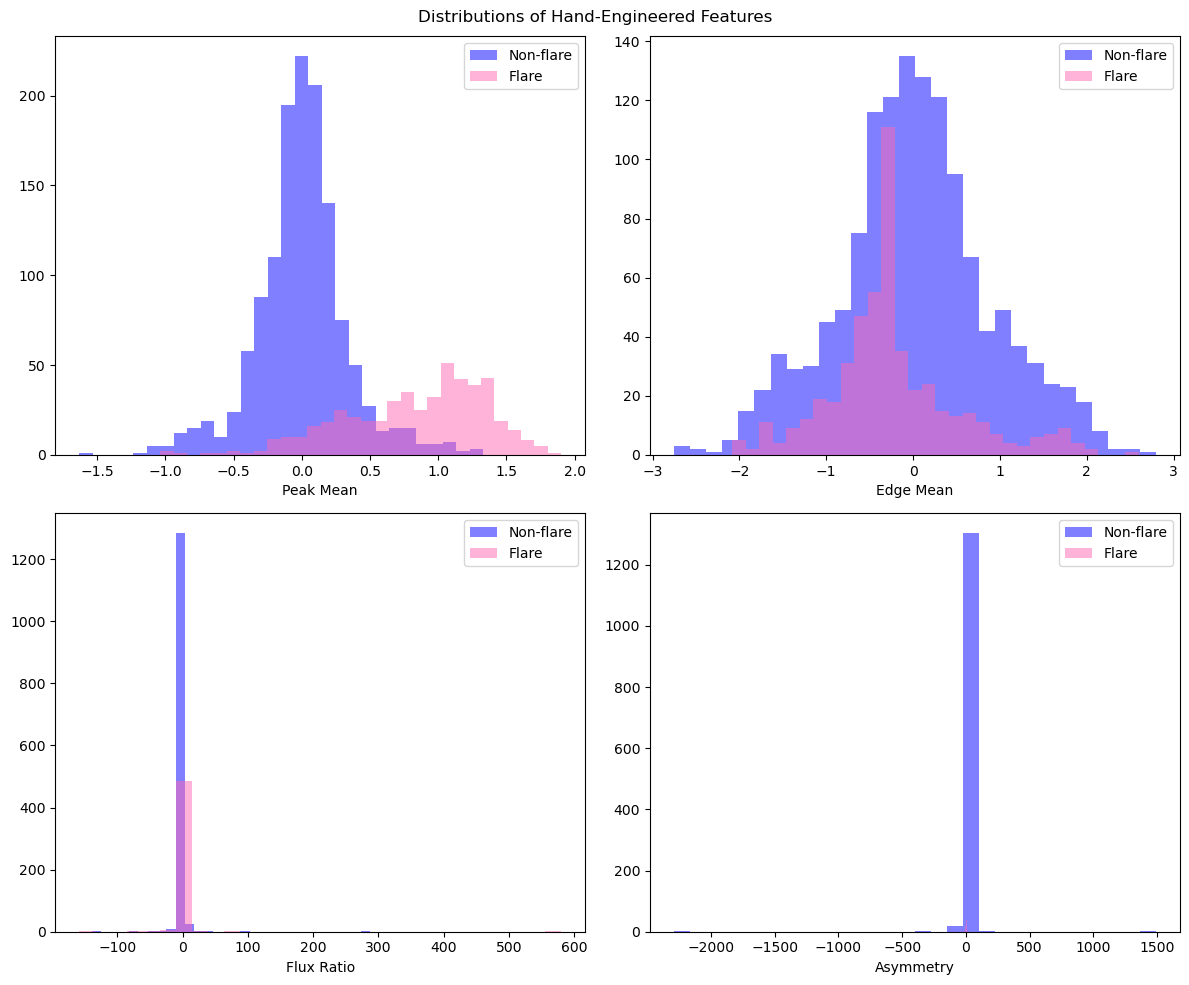

In [224]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
feature_names = ['Peak Mean', 'Edge Mean', 'Flux Ratio', 'Asymmetry']

for i, (ax, name) in enumerate(zip(axes.flatten(), feature_names)):
    ax.hist(hand_features[labels==0, i], bins=30, alpha=0.5, label='Non-flare', color='blue')
    ax.hist(hand_features[labels==1, i], bins=30, alpha=0.5, label='Flare', color='hotpink')
    ax.set_xlabel(name)
    ax.legend()

plt.suptitle('Distributions of Hand-Engineered Features')
plt.tight_layout()
plt.show()

## Question 2: Classification using Random Forests

First let's combine PCA, Fourier and Hand features into one Feature matrix. We should 10 total features: 3 PCA, 3 Fourier and 4 Hand 

In [226]:
import numpy as np
from sklearn.preprocessing import StandardScaler

all_features = np.hstack([pca_features, fft_features, hand_features])
print(f"Total features: {all_features.shape[1]}")

# Let us also standardise here:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features)

Total features: 10


### a) Decision Tree Classifier: Single Decision Tree  
I choose Gini Impurity (which uses the probability of misclassifying a random lightcurve if it were labelled according the class distirbution) as it is more computationally efficient as I was having a lot of issues with run time in prior psets. I used this instead of Entropy as I think that I have enough features to accurately classify with a simpler method (Gini). I would consider Entropy if my accuracy was low.  

In [93]:
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score

# Use sklearn single decision tree:
single_clf = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=24)

In [132]:
# Set up 4-fold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=24)

# Get predictions for all folds
label_pred = cross_val_predict(single_clf, scaled_features, labels, cv=kf)

# Calculate accuracy
accuracy = accuracy_score(labels, label_pred)
print(f"Average Accuracy: {accuracy:.4f}")

Average Accuracy: 0.9579


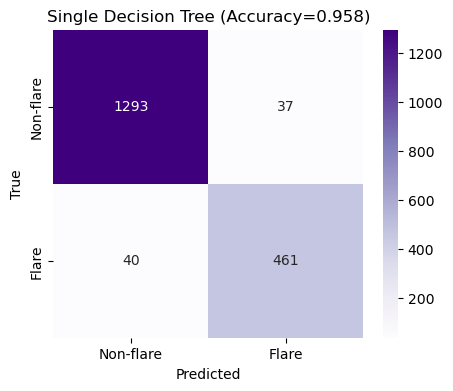

In [134]:
cm = confusion_matrix(labels, label_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Non-flare', 'Flare'], 
            yticklabels=['Non-flare', 'Flare'])
plt.title(f'Single Decision Tree (Accuracy={accuracy:.3f})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Due to high accuracy, I expect there is data leaking into one of my features so I will exmaine them below:

In [306]:
# PCA:
scaled_pca = scaler.fit_transform(pca_features)

single_clfpca = DecisionTreeClassifier(criterion='gini', random_state=4)
label_predpca = cross_val_predict(single_clf, scaled_pca, labels, cv=4) # Cross val predict 

# Calculate accuracy
accuracy = accuracy_score(labels, label_predpca)
print(f"Average Accuracy: {accuracy:.4f}")

Average Accuracy: 0.9394


Here is where I see that my PCA is very accurate, so I went back to examine it. From when I reshape my normalised curves, I exaggrate the peaks of the flares and shrink/flatten the part of the curve that is general noise present in all lightcurves. Therefore, the lightcurves of the flares are much clearer and have a distinct/easily noticeable shape to extract features from. 

In [286]:
# Fourier
scaled_fft = scaler.fit_transform(fft_features)

single_clffft = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=4)
label_predfft = cross_val_predict(single_clffft, scaled_fft, labels, cv=4)

# Calculate accuracy
accuracy = accuracy_score(labels, label_predfft)
print(f"Average Accuracy: {accuracy:.4f}")

Average Accuracy: 0.8924


In [288]:
# Hand Features
scaled_hf = scaler.fit_transform(hand_features)

single_clfhf = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=4)
label_predhf = cross_val_predict(single_clfhf, scaled_hf, labels, cv=4)

# Calculate accuracy
accuracy = accuracy_score(labels, label_predhf)
print(f"Average Accuracy: {accuracy:.4f}")

Average Accuracy: 0.8848


### b) Random Forest Classifier:
Next, train a random forest using the sklearn RandomForestClassifier.

In [111]:
from sklearn.ensemble import RandomForestClassifier

In [228]:
# Random Forest with 10 trees:
randforest10 = RandomForestClassifier(n_estimators=10, random_state=24)
randforest100 = RandomForestClassifier(n_estimators=100, random_state=24)

# Find predictions and accuracy of 10:
predictedl_10 = cross_val_predict(randforest10, scaled_features, labels, cv=4)
accuracy_10 = accuracy_score(labels, predictedl_10)

# Of 100:
predictedl_100 = cross_val_predict(randforest100, scaled_features, labels, cv=4)
accuracy_100 = accuracy_score(labels, predictedl_100)

print(f"Accuracy for 10 trees: {accuracy_10:.3f}")
print(f"Accuracy for 100 trees: {accuracy_100:.3f}")

Accuracy for 10 trees: 0.962
Accuracy for 100 trees: 0.968


Here we see that a forest with 100 trees is slightly more accurate than a forest with 10 trees.

Now let's compare depth of forests and see what impact they have:

In [230]:
rforest_depth1 = RandomForestClassifier(max_depth=1, random_state=24)
rforest_depth10  = RandomForestClassifier(max_depth=10, random_state=24)

In [232]:
# Find labels depth 1
labels_depth1 = cross_val_predict(rforest_depth1, scaled_features, labels, cv=4)
accuracy_depth1 = accuracy_score(labels, labels_depth1)

# Dpeth 10
labels_depth10 = cross_val_predict(rforest_depth10, scaled_features, labels, cv=4)
accuracy_depth10 = accuracy_score(labels, labels_depth10)

print(f"Accuracy for depth = 1: {accuracy_depth1:.3f}")
print(f"Accuracy for depth = 10: {accuracy_depth10:.3f}")

Accuracy for depth = 1: 0.901
Accuracy for depth = 10: 0.969


 By changing the hyperparameter depth, we are changing the maximum amount of splits a single tree can have. Having a smaller depth can lead to underfitting (model is too simple to detect complex patterns), but having a greater depth can lead to overfitting (model is fitted to training set and would perform poorly on other sets). 
 Here we see that having a greater depth of 10 is more accurate than a depth of 1.

So our best model based on our accuracies will be 100 trees and a depth of 10:

In [233]:
# Best model:
best_randomf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=24)
best_randomf.fit(scaled_features, labels) 

# Label predictions:
labels_best = cross_val_predict(best_randomf, scaled_features, labels, cv=4)
accuracy_best = accuracy_score(labels, labels_best)
print(f"Best Model Accuracy: {accuracy_best:.3f}")

Best Model Accuracy: 0.969


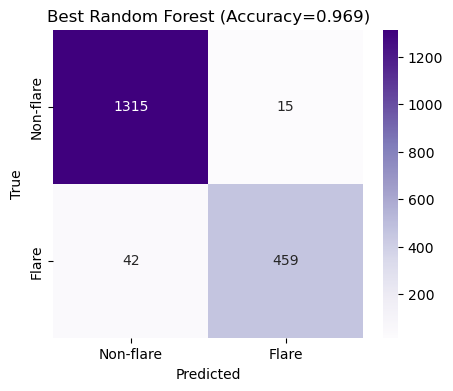

In [236]:
# Now find confusion matrix
cm = confusion_matrix(labels, labels_best)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-flare', 'Flare'],
            yticklabels=['Non-flare', 'Flare'])
plt.title(f'Best Random Forest (Accuracy={accuracy_best:.3f})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

### 1c) AdaBoost Classifier:

Start with 1 tree:

In [241]:
from sklearn.ensemble import AdaBoostClassifier

# Start with tree with dpeth of 1
start_tree = DecisionTreeClassifier(max_depth=1, random_state=42)

# Now use AdaBoost 
adaboost_1 = AdaBoostClassifier(estimator=start_tree, random_state=42)

# Cross-validate:
adapredlabel = cross_val_predict(adaboost_1, scaled_features, labels, cv=4)
accuracy_ada = accuracy_score(labels, adapredlabel)
print(f"AdaBoost (1 tree) Accuracy: {accuracy_ada:.3f}")

AdaBoost (1 tree) Accuracy: 0.967


In [257]:
# Assuming your original Decision Tree had max_depth=None or >1
single_clf = DecisionTreeClassifier(criterion='gini', splitter='best', random_state=24)
kf = KFold(n_splits=4, shuffle=True, random_state=24)
label_pred = cross_val_predict(single_clf, scaled_features, labels, cv=kf)
accuracy_dt = accuracy_score(labels, label_pred)

print(f"Decision Tree Accuracy: {accuracy_dt:.3f}")
print(f"AdaBoost 1 tree Accuracy: {accuracy_ada:.3f}")

Decision Tree Accuracy: 0.958
AdaBoost 1 tree Accuracy: 0.967


We see that Adaboost has a slightly higher accuracy. This is because AdaBoost gives more weight to misclassified samples as it goes along, so it tends to be more accurate. 

Now let's use 100 trees:

In [259]:
# Start with tree with dpeth of 1
start_tree = DecisionTreeClassifier(max_depth=1, random_state=42)

# Now use AdaBoost 
adaboost_100 = AdaBoostClassifier(estimator=start_tree, n_estimators=100, random_state=42)

# Cross-validate:
ada100predlabel = cross_val_predict(adaboost_100, scaled_features, labels, cv=4)
accuracy_ada100 = accuracy_score(labels, ada100predlabel)
print(f"AdaBoost 100 trees Accuracy: {accuracy_ada100:.3f}")

AdaBoost 100 trees Accuracy: 0.973


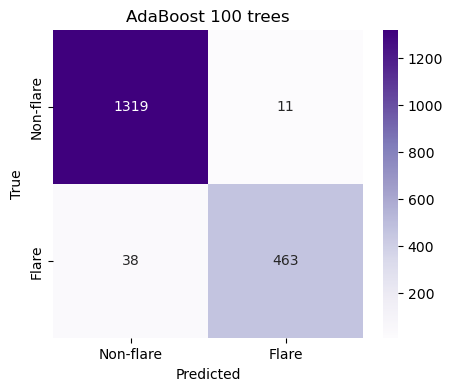

In [310]:
cm = confusion_matrix(labels, ada100predlabel)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-flare', 'Flare'],
            yticklabels=['Non-flare', 'Flare'])
plt.title('AdaBoost 100 trees')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

Adaboost works better as it learns from each tree before so it will perform better when there are 100 trees versus 1 tree. 